In [ ]:
# JsonFile Load:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d ellislunnon/car-licence-plate-detection-yolo

Dataset URL: https://www.kaggle.com/datasets/ellislunnon/car-licence-plate-detection-yolo
License(s): CC0-1.0
100% 203M/203M [00:14<00:00, 22.1MB/s]
100% 203M/203M [00:14<00:00, 14.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/car-licence-plate-detection-yolo.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split



import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 13.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.5 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
#Give the dataset path
dataset_path = '/content/licence-plates'

In [ ]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)

    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
print(the_number_in_the_string("file1252.txt"))  # Output: 123
print(the_number_in_the_string("no_numbers_here"))  # Output: 0

1252
0


In [ ]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob('/content/licence-plates/train/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()

    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text

    #Give the path of training images
    img_path = os.path.join('/content/licence-plates/train/images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/licence-plates/train/images/Cars0.png,226,419,125,173,500,268
1,/content/licence-plates/train/images/Cars1.png,134,262,128,160,400,248
2,/content/licence-plates/train/images/Cars2.png,229,270,176,193,400,400
3,/content/licence-plates/train/images/Cars3.png,142,261,128,157,400,225
4,/content/licence-plates/train/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
395,/content/licence-plates/train/images/Cars395.png,241,288,182,205,400,301
396,/content/licence-plates/train/images/Cars396.png,181,269,264,289,282,400
397,/content/licence-plates/train/images/Cars397.png,144,216,169,212,400,299
398,/content/licence-plates/train/images/Cars398.png,72,196,139,222,400,300


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 320
      len(val) = 40
      len(test) = 40



In [ ]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [ ]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
362,/content/licence-plates/train/images/Cars362.png,139,162,172,179,400,300
320,/content/licence-plates/train/images/Cars320.png,99,257,225,266,375,500
52,/content/licence-plates/train/images/Cars52.png,226,327,181,210,400,300
165,/content/licence-plates/train/images/Cars165.png,209,293,217,254,590,343
354,/content/licence-plates/train/images/Cars354.png,65,102,202,222,400,267
...,...,...,...,...,...,...,...
387,/content/licence-plates/train/images/Cars387.png,163,256,187,225,430,286
59,/content/licence-plates/train/images/Cars59.png,324,375,162,175,400,300
14,/content/licence-plates/train/images/Cars14.png,94,274,118,163,400,225
87,/content/licence-plates/train/images/Cars87.png,3,45,205,220,400,290


In [ ]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)

    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [ ]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [ ]:
os.getcwd()

'/content'

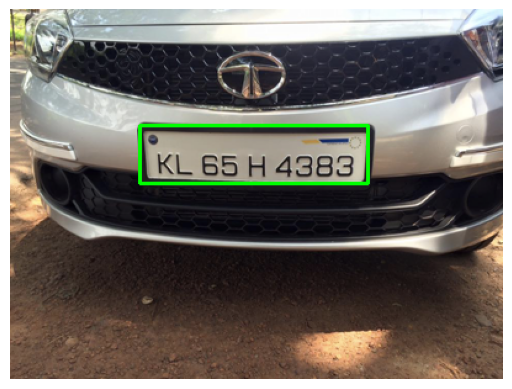

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[100]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [ ]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# **Using Yolo**

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 295MB/s]


In [ ]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=50,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

100%|██████████| 755k/755k [00:00<00:00, 106MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/datasets/cars_license_plate_new/train/labels... 320 images, 0 backgrounds, 0 corrupt: 100%|██████████| 320/320 [00:00<00:00, 686.42it/s]

train: New cache created: /content/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 320/320 [00:04<00:00, 78.25it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/cars_license_plate_new/val/labels... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 740.43it/s]

val: New cache created: /content/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 40/40 [00:00<00:00, 70.57it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.656G      1.717      3.026      1.329         34        320: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         40         40    0.00348       0.95      0.271      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.596G      1.567      1.596      1.194         23        320: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]

                   all         40         40    0.00384       0.95     0.0897     0.0357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.596G      1.513      1.378      1.195         29        320: 100%|██████████| 20/20 [00:04<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.77it/s]

                   all         40         40      0.158       0.05      0.109     0.0548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.61G      1.558      1.379      1.232         20        320: 100%|██████████| 20/20 [00:03<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


                   all         40         40      0.736      0.425      0.496      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.61G      1.545      1.319      1.252         31        320: 100%|██████████| 20/20 [00:02<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.10it/s]

                   all         40         40      0.583      0.425        0.5      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50     0.604G      1.434      1.221      1.186         31        320: 100%|██████████| 20/20 [00:02<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


                   all         40         40      0.648        0.3      0.362      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50     0.602G      1.491      1.199        1.2         26        320: 100%|██████████| 20/20 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]

                   all         40         40       0.29       0.45      0.226     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.602G      1.429      1.177       1.18         28        320: 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         40         40      0.673      0.575      0.618      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.604G       1.45      1.052      1.209         21        320: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.41it/s]

                   all         40         40      0.909        0.7       0.72      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.602G      1.448       1.01      1.171         28        320: 100%|██████████| 20/20 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


                   all         40         40      0.955      0.625      0.787      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.602G      1.433      1.027      1.187         44        320: 100%|██████████| 20/20 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

                   all         40         40      0.924       0.85      0.894       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.602G      1.404     0.9428      1.182         35        320: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         40         40      0.868      0.819      0.882      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50     0.602G      1.355      0.927      1.148         28        320: 100%|██████████| 20/20 [00:04<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.67it/s]

                   all         40         40      0.835       0.85      0.838      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50     0.602G      1.357     0.9296      1.146         38        320: 100%|██████████| 20/20 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         40         40      0.886        0.8      0.826      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.604G      1.303     0.8996      1.117         28        320: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


                   all         40         40      0.878       0.85      0.873      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.604G      1.293     0.8495      1.102         28        320: 100%|██████████| 20/20 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.58it/s]

                   all         40         40      0.937      0.775      0.861      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.602G       1.26     0.8548      1.114         33        320: 100%|██████████| 20/20 [00:03<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         40         40      0.839        0.8       0.83      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.604G      1.256     0.8366      1.108         33        320: 100%|██████████| 20/20 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]

                   all         40         40       0.85      0.853      0.884      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.604G      1.264     0.8429      1.112         27        320: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.24it/s]

                   all         40         40      0.957      0.875      0.897      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.604G      1.255     0.8184      1.137         26        320: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         40         40      0.943      0.775      0.852      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50     0.604G      1.278     0.8128      1.118         37        320: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.00it/s]

                   all         40         40      0.864      0.875        0.9      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.602G      1.224     0.8124      1.098         31        320: 100%|██████████| 20/20 [00:04<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]

                   all         40         40      0.877      0.895      0.903      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.604G      1.244     0.7933      1.114         22        320: 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

                   all         40         40      0.892      0.875      0.891      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.602G      1.186     0.7861      1.076         33        320: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         40         40      0.851      0.875      0.885      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.602G      1.161     0.7496      1.063         43        320: 100%|██████████| 20/20 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         40         40      0.869      0.875      0.876      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.602G      1.146     0.7237      1.088         35        320: 100%|██████████| 20/20 [00:02<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

                   all         40         40       0.95       0.85      0.922      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.604G      1.209     0.7504      1.094         29        320: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.60it/s]

                   all         40         40      0.911      0.875      0.921       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50     0.604G      1.146     0.7133       1.08         32        320: 100%|██████████| 20/20 [00:02<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


                   all         40         40      0.939      0.768      0.874      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50     0.604G      1.126     0.7034      1.059         30        320: 100%|██████████| 20/20 [00:02<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         40         40      0.953      0.825      0.897      0.515

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.604G      1.087     0.7081      1.055         27        320: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]

                   all         40         40      0.869      0.831      0.864      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.602G      1.076        0.7      1.037         26        320: 100%|██████████| 20/20 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

                   all         40         40      0.887        0.8      0.858      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.604G      1.098     0.6934      1.049         38        320: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]


                   all         40         40      0.908       0.85      0.902      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.602G      1.083     0.6722       1.03         31        320: 100%|██████████| 20/20 [00:02<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]

                   all         40         40      0.995        0.9      0.959      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.602G      1.016     0.6554      1.016         36        320: 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]

                   all         40         40      0.941       0.85       0.93      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.604G      1.016     0.6316      1.006         31        320: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         40         40      0.853      0.871      0.903       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50     0.602G      1.036     0.6619      1.031         31        320: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]

                   all         40         40      0.892       0.85      0.887      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.604G      1.008     0.6332      1.021         31        320: 100%|██████████| 20/20 [00:02<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.69it/s]

                   all         40         40      0.872      0.849      0.866      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.602G      1.014     0.6223      1.019         22        320: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

                   all         40         40      0.897      0.869      0.921      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.602G      1.049     0.6326      1.014         33        320: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         40         40      0.891      0.821      0.902      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.602G     0.9614     0.6146       1.01         34        320: 100%|██████████| 20/20 [00:02<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         40         40      0.914       0.85      0.912      0.533


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.621G      1.236     0.7606       1.11         16        320: 100%|██████████| 20/20 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.65it/s]

                   all         40         40      0.875      0.874      0.904       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       0.6G      1.199      0.709      1.083         16        320: 100%|██████████| 20/20 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         40         40      0.892      0.925      0.942      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       0.6G      1.211     0.6647      1.096         16        320: 100%|██████████| 20/20 [00:02<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         40         40      0.848      0.875      0.865      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       0.6G      1.126     0.6532      1.066         16        320: 100%|██████████| 20/20 [00:02<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         40         40        0.9      0.898      0.902       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       0.6G      1.131     0.6273      1.054         16        320: 100%|██████████| 20/20 [00:04<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.69it/s]

                   all         40         40       0.92      0.858      0.914      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       0.6G      1.088     0.6035       1.04         15        320: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         40         40      0.956      0.875      0.951      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       0.6G      1.097     0.6226      1.047         16        320: 100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         40         40      0.902      0.925      0.951      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       0.6G      1.102     0.6287      1.045         16        320: 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]


                   all         40         40      0.876        0.9      0.922      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       0.6G      1.063     0.6192      1.047         15        320: 100%|██████████| 20/20 [00:02<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         40         40      0.966      0.875      0.956      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       0.6G      1.068     0.6039      1.029         16        320: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         40         40        0.9      0.925      0.956      0.557



50 epochs completed in 0.055 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


                   all         40         40        0.9      0.925      0.956      0.565
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aded5fc5540>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

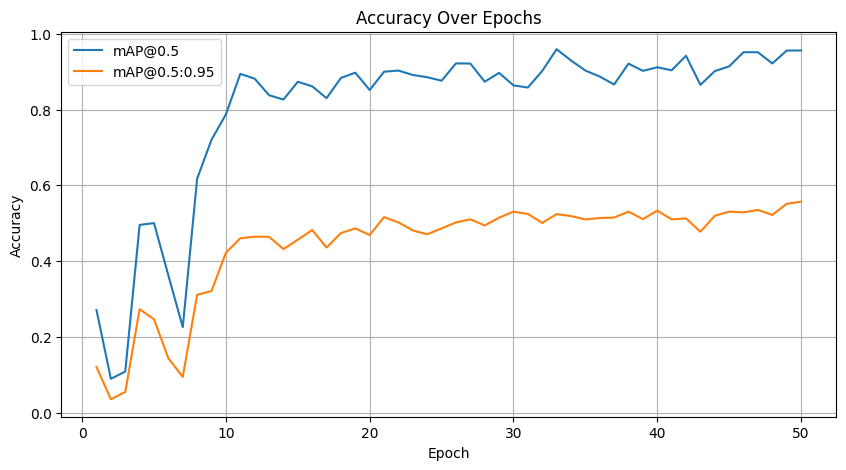

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [ ]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /content/licence-plates/train/images/Cars9.png: 256x320 1 license_plate, 63.8ms
Speed: 1.2ms preprocess, 63.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)


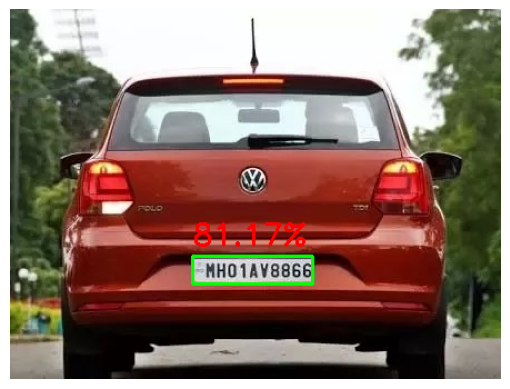

In [ ]:
predict_and_plot(test.iloc[10].img_path)